# Generate a PPi train + validation set from [APID](http://cicblade.dep.usal.es:8080/APID/init.action) and a Y2H test set from [HuRI](http://www.interactome-atlas.org/download)
## prep

- March 2021 version of [APID](http://cicblade.dep.usal.es:8080/APID/init.action)
- interactomes for the 35 organisms listed as "with more than 500 interactions" only
- some organism datasets will be dropped later, so not fetching smaller sets is ok
- binary interactomes -> Level 2 -> `Q1` suffix
- not using *H. sapiens* for training -> `9606_*Q1.txt`


Preliminary loss from leaving out inter-species PPIs and the human interactome. First the number of IDs, then the number of PPIs:

| APID     |              ISI |            noISI |      loss |
|---------:|:----------------:|:----------------:|:---------:|
| w/ Human | 67'240 : 319'429 | 61'429 : 296'653 | .09 : .07 |
| no Human | 55'014 : 179'349 | 45'026 : 161'598 | .18 : .10 |
|     loss |    .18 : .44     |    .27 : .46     | .33 : .49 |

In [3]:
from __future__ import annotations

import os
import sys
import shutil
import importlib

from pathlib import Path

from dataclasses import dataclass, field

import numpy as np
import pandas as pd
from dataclass_wizard import JSONWizard

Mess around with paths because I'm running this a few times on different system.

In [4]:
!which python
!pwd

/home/quirin/mambaforge/envs/ppi/bin/python
/home/quirin/PYTHON/ppi/data/ppi_dataset/template


In [5]:
if 'kaindl' in str(cwd := Path.cwd()):
    cwd = Path('/home/k/kaindll/ppi/data/ppi_dataset/template')
package_root = str(cwd.parents[2])
if package_root not in sys.path:
    sys.path.append(package_root)
package_root

'/home/quirin/PYTHON/ppi'

In [6]:
session = '7074'
session_dir = cwd.parent / 'results' / session

if not session_dir.is_dir():
    shutil.copytree(cwd, session_dir, symlinks=False,
                    ignore=shutil.ignore_patterns('*.ipynb', '*.png'),
                    dirs_exist_ok=True)
os.chdir(session_dir.resolve())
!pwd

/home/quirin/PYTHON/ppi/data/ppi_dataset/results/7074


In [7]:
from data.utils.cfg import Config, SamplingStrategy
from data.utils import api, extract, general, pairs, plot, reduce, proteome

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

#### config
These are the somewhat relevant settings. Have a look!

In [8]:

@dataclass
class Params(JSONWizard):
    class _(JSONWizard.Meta):
        key_transform_with_dump = 'SNAKE'

    keep_human: bool = False
    keep_interspecies: bool = False
    accept_homodimers: bool = False
    add_proteomes: bool = True
    slurm: bool = all(shutil.which(t) for t in ('snakemake', 'sbatch'))
    slurm_node_limit: int = 15
    rostclust: bool = shutil.which('rostclust')

    min_seq_len: int = 50
    max_seq_len: int = 1500

    seed: int = 42
    ratio: float = 10.0
    strategy: SamplingStrategy = SamplingStrategy.BALANCED

    val_set_size: float = .1
    val_species: Set[str] = field(default_factory=set)


hval_config = dict(shortAlignmentLen=50,
                   longSeqLen=180,
                   reduceRandomAlign=False,
                   clusterThreshold=20)

val_species = {237561, 37296, 9031, 8355, 9913, 7955, 39947, 10116, 36329, 224308}
train_species = None  # select only this subset
params = Params()

The detour below is meant to keep the class definition above short, and the `Config` class importable from other modules.

In [9]:
c = Config(
    **params.to_dict() | dict(
        hval_config=hval_config, val_species=val_species,
        cwd=session_dir, strategy=params.strategy
    ))

#### importlib
For development, it's nice to be able to edit the imported modules.

## Toy example
#### bias of negative dataset

In [283]:
# demonstrate sampling strategies: toy PPI table example
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK'''
ppis = ppis_from_string(raw)
ppi_dict = dict()
ppis

,0,1
0,A,B
1,A,C
2,C,F
3,A,E
4,K,L
5,C,K
6,B,G
7,G,M
8,A,O
9,E,O


In [284]:
ppi_dict['balanced'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42, strategy=SamplingStrategy.BALANCED))
# balanced sampling tries to conserve the distribution of degrees -> high-bias dataset

In [285]:
ppi_dict['random'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42, strategy=SamplingStrategy.RANDOM))
# random sampling gives a nearly un-biased dataset

In [286]:
ppi_dict['complement'], *_ = find_negative_pairs(
    ppis, Config(ratio=10, seed=42, strategy=SamplingStrategy.BALANCED))
# sampling the entire network complement will perfectly invert the degree distribution

#### strategies visualized
It becomes apparent that the combination of graph size and density is important, and that random or balanced sampling generate different sets of negatives.

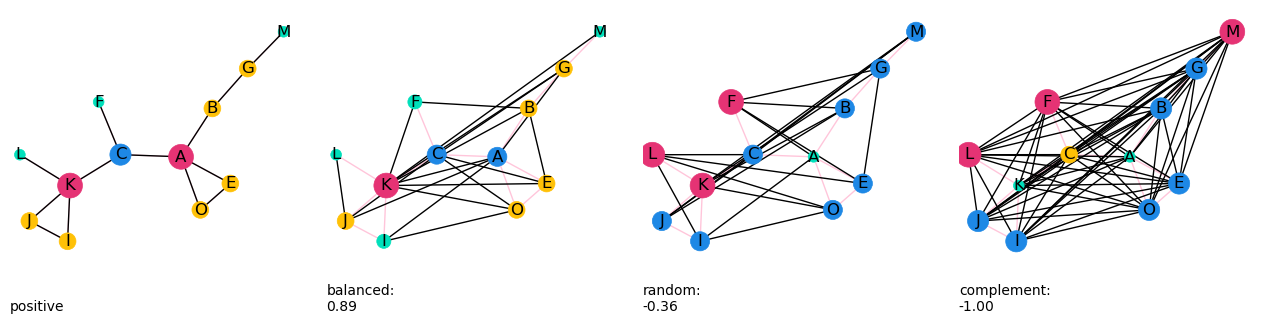

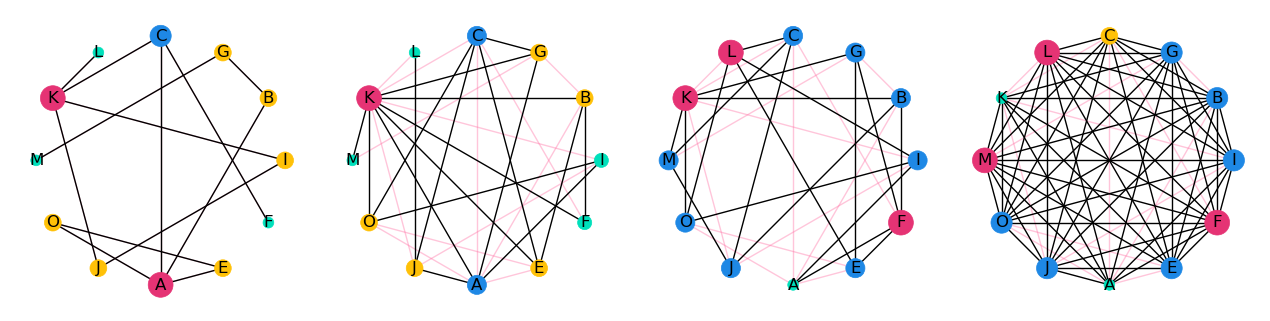

In [197]:
_ = draw_toy_ppis(ppis, ppi_dict)

#### with homodimers

In [198]:
# added F-F
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK\nF\tF'''
ppis = ppis_from_string(raw)

In [199]:
ppi_dict = dict()
ppi_dict['balanced'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42, strategy=SamplingStrategy.BALANCED))
ppi_dict['random'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42, strategy=SamplingStrategy.RANDOM))
ppi_dict['complement'], *_ = find_negative_pairs(
    ppis, Config(ratio=10, seed=42, strategy=SamplingStrategy.BALANCED))
# _ = draw_toy_ppis(ppis, ppi_dict)

#### input homodimers, but not allowed as negatives

In [200]:
ppi_dict = dict()
ppi_dict['balanced'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42,
                 strategy=SamplingStrategy.BALANCED,
                 accept_homodimers=False))
ppi_dict['random'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42,
                 strategy=SamplingStrategy.RANDOM,
                 accept_homodimers=False))
ppi_dict['complement'], *_ = find_negative_pairs(
    ppis, Config(ratio=10, seed=42,
                 strategy=SamplingStrategy.BALANCED,
                 accept_homodimers=False))
# _ = draw_toy_ppis(ppis, ppi_dict)

## Train set: APID
#### extract from `<taxid>*_Q1.txt` files

In [201]:
c.qp = unzip_apid(zip_path='apid.zip', keep_human=c.keep_human,
                  keep_interspecies=c.keep_interspecies)
c.qp

PosixPath('apid_q1')

In [202]:
uniprot_ids = extract_apid_uniprot_ids(c.qp)
len(uniprot_ids)

45026

In [203]:
ppis = extract_apid_ppis(c.qp)
len(ppis)

161598

In [204]:
ppis.head()

,UniprotID_A,UniprotID_B,species
0,O05731,O24991,85962
1,O24866,O24991,85962
2,O24877,O25423,85962
3,O24881,O25094,85962
4,O24881,O25356,85962


#### select small subset

In [205]:
if train_species:
    ppis = ppis.loc[ppis.species.isin(train_species | c.val_species)]
    uniprot_ids = set(np.unique(ppis.iloc[:, [0, 1]]))
len(ppis), len(uniprot_ids)

(161598, 45026)

#### interspecies interactions
Check if there are PPIs (based on UniProt IDs) that occur in several species. We use APID `noISI` data per default, so the exclusion of this data is not implemented.

In [206]:
find_multi_species_ppis(ppis)

,UniprotID_A,UniprotID_B,species


In [207]:
# proof that actually worked: add some dummy data
for i in [0, 1]:
    s = ppis.iloc[i].copy()
s.species = 'marsupilami'
ppis = pd.concat([ppis, pd.DataFrame(s).T], axis=0)

marsu = find_multi_species_ppis(ppis)

# drop the dummy data
ppis = ppis.loc[ppis.species != 'marsupilami']
marsu

,UniprotID_A,UniprotID_B,species
1,O24866,O24991,85962
1,O24866,O24991,marsupilami


or more generally protein IDs that occur in several species:

In [208]:
find_multi_species_proteins(ppis)

,UniprotID,species


#### download sequences

In [209]:
# # skip if re-running this w/o changes above or deleting files
# _ = uniprot_api_fetch(uniprot_ids, c.ap / 'apid')

#### map IDs to seq hashes

In [210]:
hash_ppis = ppis_to_hashes(ppis, c.ap / 'apid.json').drop_duplicates()
hash_ppis.head()

,hash_A,hash_B,species
3,CRC-48F409F4E28F37BE,CRC-9AC87796A0BA67D9,632
1,CRC-4A7DEB955583CB27,CRC-6D6C1B4ED5C94EC7,632
0,CRC-5E21543540EBF92B,CRC-8561A9A0C1A2E169,632
2,CRC-8049DCC1A80C7391,CRC-9AC87796A0BA67D9,632
4,CRC-9AC87796A0BA67D9,CRC-9AC87796A0BA67D9,632


In [211]:
len(ppis) - len(hash_ppis)

1030

In [212]:
fasta = SeqIO.to_dict(SeqIO.parse(c.ap / 'apid.hash.fasta', 'fasta'))
len(fasta)

44707

#### filter by seq length

In [213]:
c.min_seq_len, c.max_seq_len

(50, 1500)

dropped 9425/160568 PPIs from length filtering
dropped 0/42505 table IDs and 0/151143 rows, and 2202/44707 sequence IDs


(44707, 42505)

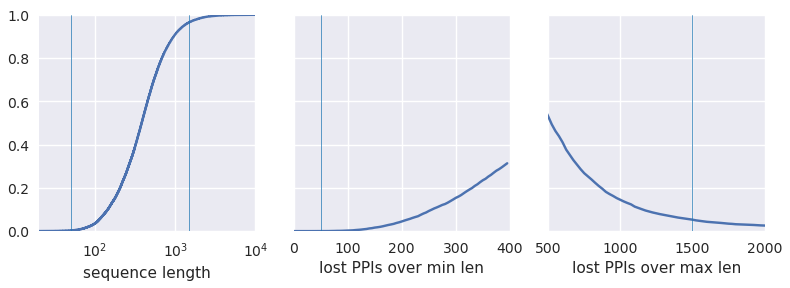

In [214]:
_hash_ppis, _fasta, _ = filter_ppis_and_fasta_by_len(
    hash_ppis, fasta, c.min_seq_len, c.max_seq_len)
len(fasta), len(_fasta)

continue if these limits were ok, or change/set the values for
`cfg.min_seq_len, cfg.max_seq_len` and re-run the filtering cell

In [215]:
hash_ppis = _hash_ppis
fasta = _fasta

#### homodimer share
Overall count, share, overall PPI count

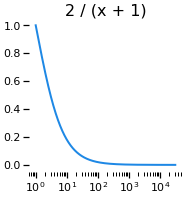

In [216]:
with mpl.rc_context({'figure.dpi': 36}):
    _ = plot_theoretical_homodimer_share()

(False, 4249, 0.0281, 151143)

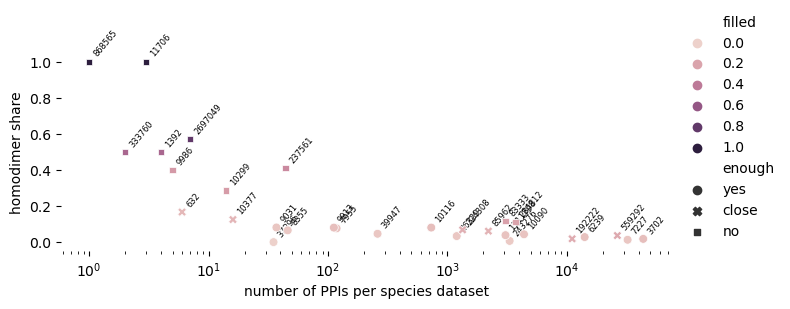

In [217]:
_ = plot_homodimer_share(hash_ppis, c.ratio)
c.accept_homodimers, *count_homodimers(hash_ppis),

In [218]:
if not c.accept_homodimers:
    hash_ppis = drop_homodimers(hash_ppis)
hash_ppis, fasta = shrink_both_ways(hash_ppis, fasta)
len(hash_ppis), len(fasta)

dropped 0/42053 table IDs and 0/146894 rows, and 452/42505 sequence IDs


(146894, 42053)

#### degree distributions
Look at some of those. In the next step, we will try to identify interactions between hubs and proteins that occur only once; and remove those PPIs. This will shrink the set of proteins and the degree of the hub; and we'll need less SwissProt proteins for it.

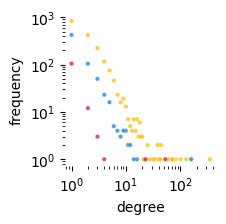

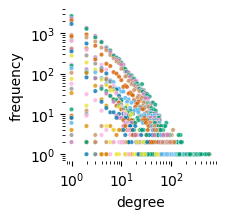

In [221]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degree_distribution(hash_ppis.loc[hash_ppis.species.isin(
        [7955, 10116, 284812])].copy(), 2.4)
    fg._legend.remove()
    # for sfx in ['svg', 'png']:
    #     fg.savefig(f'degree_distrs.{sfx}', dpi=300)

    fg = plot_degree_distribution(hash_ppis)
    fg._legend.remove()

#### remove proteins that only interact with an über-hub?
so that we need less extra proteins. Either directly remove hubs and hope that also drops a lot of proteins that interact only with them; or directly remove proteins that only interact with hubs.

First squint at numbers a bit: At what percentage do overkill-hubs start?

In [222]:
fetch_degrees(hash_ppis).groupby('species')['degree'].describe(percentiles=[.9, .95, .98])

,count,mean,std,min,50%,90%,95%,98%,max
species,,,,,,,,,
632,9.0,1.111111,0.333333,1.0,1.0,1.2,1.60,1.84,2.0
1392,4.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.00,1.0
3702,9042.0,9.465605,23.636010,1.0,3.0,22.0,35.00,60.18,570.0
6239,5108.0,5.361785,11.568742,1.0,2.0,12.0,21.00,38.00,232.0
7227,8522.0,7.470547,12.544502,1.0,3.0,19.0,29.00,45.00,327.0
7955,123.0,1.772358,5.079391,1.0,1.0,2.0,2.00,3.56,53.0
8355,68.0,1.264706,0.682787,1.0,1.0,2.0,2.00,4.00,4.0
9031,54.0,1.259259,0.520710,1.0,1.0,2.0,2.00,2.94,3.0
9913,106.0,1.943396,2.041616,1.0,1.0,5.0,7.00,7.90,12.0


Fetch the node degrees and protein numbers

In [223]:
ppi_dgs = fetch_degrees(hash_ppis, as_dict=True)
p_dgs = fetch_n_proteins(hash_ppis).to_dict()
for ch, num in zip('AB', '01'):
    hash_ppis[f'degree_{num}'] = hash_ppis[f'hash_{ch}'].apply(ppi_dgs.get)

# sort the two columns of degrees
hash_ppis[['degree_0', 'degree_1']] = np.sort(
    hash_ppis[['degree_0', 'degree_1']], axis=1)
hash_ppis['n_seqs'] = hash_ppis.species.apply(p_dgs.get)
hash_ppis.head()

,hash_A,hash_B,species,minlen,maxlen,degree_0,degree_1,n_seqs
3,CRC-48F409F4E28F37BE,CRC-9AC87796A0BA67D9,632,170,833,1,2,9
1,CRC-4A7DEB955583CB27,CRC-6D6C1B4ED5C94EC7,632,266,334,1,1,9
0,CRC-5E21543540EBF92B,CRC-8561A9A0C1A2E169,632,95,326,1,1,9
2,CRC-8049DCC1A80C7391,CRC-9AC87796A0BA67D9,632,170,258,1,2,9
5,CRC-BED64D5961AA5E38,CRC-D4C3706260D2937A,632,207,780,1,1,9


In [224]:
# find the pairs
greedy = 2
dppis = hash_ppis.loc[(hash_ppis.degree_0 == 1) & (hash_ppis.degree_1 >= hash_ppis.n_seqs / c.ratio / greedy)].copy()
len(dppis), len(hash_ppis), 'of pairs will drop ...'

(942, 146894, 'of pairs will drop ...')

In [225]:
_hash_ppis = hash_ppis.iloc[~hash_ppis.index.isin(dppis.index)].copy()
_hash_ppis, _fasta = shrink_both_ways(_hash_ppis, fasta.copy())
len(_hash_ppis), len(hash_ppis), len(_fasta), len(fasta)

dropped 0/39463 table IDs and 0/138381 rows, and 2590/42053 sequence IDs


(138381, 146894, 39463, 42053)

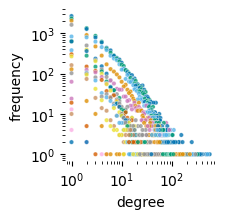

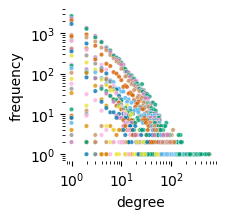

In [226]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degree_distribution(_hash_ppis, 2.4)
    fg._legend.remove()
    # the og one
    fg = plot_degree_distribution(hash_ppis, 2.4)
    fg._legend.remove()

In [236]:
if False:  # of course off by default
    hash_ppis = _hash_ppis
    fasta = _fasta

#### species lookup
Cheating here: the `59251` fell from the sky

In [239]:
taxonomy = fetch_taxonomic_info(pd.concat((
    hash_ppis.species, pd.Series([9606] * 59251))
).rename('species')).sort_values(by='n_ppis')
taxonomy['set_name'] = ''
taxonomy.loc[taxonomy.species.isin(c.train_species), 'set_name'] += '_train'
taxonomy.loc[taxonomy.species.isin(c.val_species), 'set_name'] += '_validate'
taxonomy.loc[taxonomy.species == 9606, 'set_name'] = 'test'
taxonomy.set_name = taxonomy.set_name.str.lstrip('_')
taxonomy.loc[taxonomy.name.str.startswith('Campylob'), 'name'] = 'Campylobacter jejuni'
taxonomy.loc[taxonomy.name.str.startswith('Sever'), 'name'] = 'SARS-CoV 2'
taxonomy

100%|██████████| 29/29 [00:07<00:00,  3.71it/s]


,species,name,n_ppis,set_name
25,333760,Human papillomavirus type 16,1,train
1,1392,Bacillus anthracis,2,train
28,2697049,SARS-CoV 2,3,train
10,9986,Oryctolagus cuniculus,3,train
0,632,Yersinia pestis,5,train
13,10299,Human alphaherpesvirus 1 strain 17,10,train
14,10377,Human herpesvirus 4 strain B95-8,14,train
22,237561,Candida albicans SC5314,26,validate
7,9031,Gallus gallus,34,validate
16,37296,Human gammaherpesvirus 8,35,validate


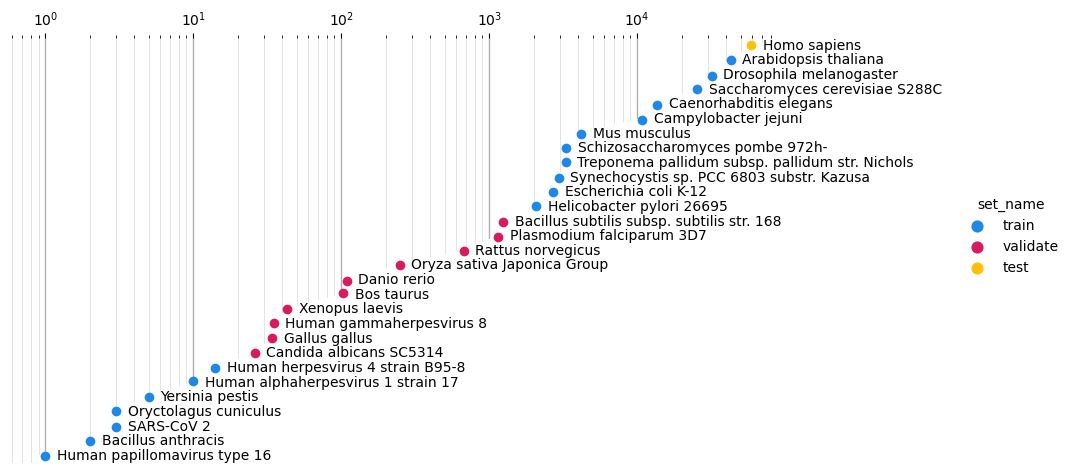

In [241]:
_ = plot_interactome_sizes(taxonomy)

#### download proteomes

In [230]:
# # skip if re-running this w/o changes above or deleting files
# if c.add_proteomes:
#     fetch_proteomes(set(taxonomy.species) | {9606}, c.pp)

## Validation set: APID
#### val: select species/proteins
Either by sampling a subset of proteins and selecting the PPIs or picking the ones for one or more particular species

In [231]:
c.val_set_size, c.val_species

(0.1, {7955, 8355, 9031, 9913, 10116, 36329, 37296, 39947, 224308, 237561})

In [232]:
taxonomy.loc[taxonomy.species.isin(c.val_species)]

,species,name,n_ppis
21,237561,Candida albicans SC5314,26
7,9031,Gallus gallus,34
15,37296,Human gammaherpesvirus 8,35
6,8355,Xenopus laevis,43
8,9913,Bos taurus,103
5,7955,Danio rerio,109
16,39947,Oryza sativa Japonica Group,248
11,10116,Rattus norvegicus,673
14,36329,Plasmodium falciparum 3D7,1156
20,224308,Bacillus subtilis subsp. subtilis str. 168,1247


In [233]:
hash_ppis['label'] = 1
if c.val_species is not None:
    train, val = make_validation_species(hash_ppis, c.val_species)
else:
    # if the set becomes too large, try another seed!
    # With this approach, PPIs *will* be lost
    train, val = make_validation_split(hash_ppis, c.val_set_size, c.seed)
c.val_species = set(val.species)
c.train_species = set(train.species)
len(train), len(train) / len(hash_ppis), len(val), len(val) / len(hash_ppis)

(143220, 0.9749887674105137, 3566, 0.02427600855038327)

In [234]:
val.head()

,hash_A,hash_B,species,minlen,maxlen,degree_0,degree_1,n_seqs,label
122,CRC-000BC5DD420D0669,CRC-2808F51BBD3A8B6E,7955,264,363,1,1,123,1
19,CRC-0B5D3548EEF911AE,CRC-F5A8EAFC27AD733E,7955,574,940,1,3,123,1
65,CRC-0E6AE7E0F9C5520F,CRC-3C5E4EDDF27EACFF,7955,424,999,1,23,123,1
20,CRC-12077214EFED46D0,CRC-F5A8EAFC27AD733E,7955,558,940,1,3,123,1
85,CRC-12A7DE26809AAAF4,CRC-DAB541D403215A02,7955,169,1030,1,53,123,1


In [235]:
val.species.unique(), train.species.unique()

(array([  7955,   8355,   9031,   9913,  10116,  36329,  37296,  39947,
        224308, 237561]),
 array([    632,    1392,    3702,    6239,    7227,    9986,   10090,
          10299,   10377,   83333,   85962,  192222,  243276,  284812,
         333760,  559292, 1111708, 2697049]))

Separate the validation set sequences from the ones remaining as train set

#### train: save seqs + positives


In [42]:
_, train_seqs = shrink_both_ways(train.copy(), fasta.copy())
c.train_seqs = len(train_seqs)
len(train_seqs), len(fasta)

dropped 0/39789 table IDs and 0/147225 rows, and 2716/42505 sequence IDs


(39789, 42505)

In [43]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_raw_fasta, 'fasta')
train.to_csv(c.train_raw_tsv, sep='\t', header=True, index=False)
c.train_raw_fasta, c.train_raw_tsv

(PosixPath('apid/apid_train_raw.fasta'), PosixPath('apid/apid_train_raw.tsv'))

#### val: save seqs + positives

In [44]:
_, val_seqs = shrink_both_ways(val.copy(), fasta.copy())
len(val_seqs), len(fasta)

dropped 0/2694 table IDs and 0/3807 rows, and 39811/42505 sequence IDs


(2694, 42505)

In [45]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_raw_fasta, 'fasta')
val.to_csv(c.val_raw_tsv, sep='\t', header=True, index=False)
c.val_raw_fasta, c.val_raw_tsv

(PosixPath('apid/apid_validation_raw.fasta'),
 PosixPath('apid/apid_validation_raw.tsv'))

Mind that the TSVs will contain only positives! Sample negatives only after most of the `uniqueprot`-shebang.

## Test set: HuRI
#### download and extract PPIs

In [46]:
c.psi_path

PosixPath('hi_union.psi')

In [47]:
# it's somehow a lot faster to download this from a browser!
# or run !wget "http://www.interactome-atlas.org/data/HI-union.psi" -O "hi_union.psi"
download_y2h_interactome(c.psi_path)

already downloaded and SHA256 checks out


PosixPath('hi_union.psi')

In [48]:
huri_ppis, huri_seq_ids = extract_huri_ppis(c.psi_path)
len(huri_ppis)

97888

#### pick a subset?

In [251]:
frac = 6
huri_ids = np.unique(huri_ppis.iloc[:, [0, 1]])
len(train), len(val), len(val_seqs) + len(train_seqs) + len(huri_ids) // frac

In [ ]:
rng = np.random.default_rng(12345)
chc = set(rng.choice(huri_ids, size=len(huri_ids) // frac))
len(chc), list(chc)[:10]

In [ ]:
_huri_ppis = huri_ppis.loc[(huri_ppis[0].isin(chc)) & (huri_ppis[1].isin(chc))]
_huri_ppis

In [257]:
if False:  # off by default
    huri_ppis = _huri_ppis
    for k in huri_seq_ids.keys():
        huri_seq_ids[k] = {v for v in huri_seq_ids[k] if v in chc}

In [49]:
# now back to normal
huri_seqs, _ = fetch_huri_seqs(huri_seq_ids, c.hp / 'huri')
len(huri_seqs)

archive batch: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


uniprot:

hash FASTA: 9040it [00:02, 4282.73it/s]
fetch isoforms/archive: 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


9119

#### map + filter PPIs

In [50]:
print(set(huri_ppis.species))  # only human, but keep the label
huri_ppis.head()

{9606}


,0,1,species
0,P0DP25,A0A087WXN0,9606
1,Q68D86-1,Q9HD26-2,9606
2,Q13515,Q9UJW9,9606
3,P30049,Q05519-2,9606
4,ENSP00000462298,P43220,9606


In [51]:
# some 35K protein IDs point to the same sequence
huri_hash_ppis = ppis_to_hashes(huri_ppis, c.hp / 'huri.json')
len(huri_ppis), len(huri_ppis) - len(huri_hash_ppis), len(huri_hash_ppis)

(97888, 35329, 62559)

In [52]:
huri_hash_ppis.head()

,hash_A,hash_B,species
22905,CRC-000037AE195F7A9D,CRC-82152E496B924EEC,9606
143452,CRC-000624825E507385,CRC-C116E348E8B7AD2B,9606
62304,CRC-000624825E507385,CRC-D7C7F6F2CD922775,9606
7538,CRC-000CFE2B83394B42,CRC-40C7C3686632F6A7,9606
27848,CRC-0012F055C7F2A233,CRC-2E96FD0179EE119D,9606


In [53]:
# make sure we don't test on sequences that we trained on;
# A LOT more checks later
huri_hash_ppis = remove_ids_from(
    huri_hash_ppis, black_list_fasta=c.train_raw_fasta)
len(huri_hash_ppis)

61162

In [54]:
*count_homodimers(huri_hash_ppis), c.accept_homodimers

(751, 0.0123, 61162, True)

In [55]:
if not c.accept_homodimers:
    huri_hash_ppis = drop_homodimers(huri_hash_ppis)
huri_hash_ppis, huri_seqs = shrink_both_ways(huri_hash_ppis, huri_seqs)
len(huri_hash_ppis), len(huri_seqs)

dropped 0/8985 table IDs and 0/61162 rows, and 134/9119 sequence IDs


(61162, 8985)

dropped 1208/61162 PPIs from length filtering
dropped 0/8805 table IDs and 0/59954 rows, and 180/8985 sequence IDs


(8985, 8805)

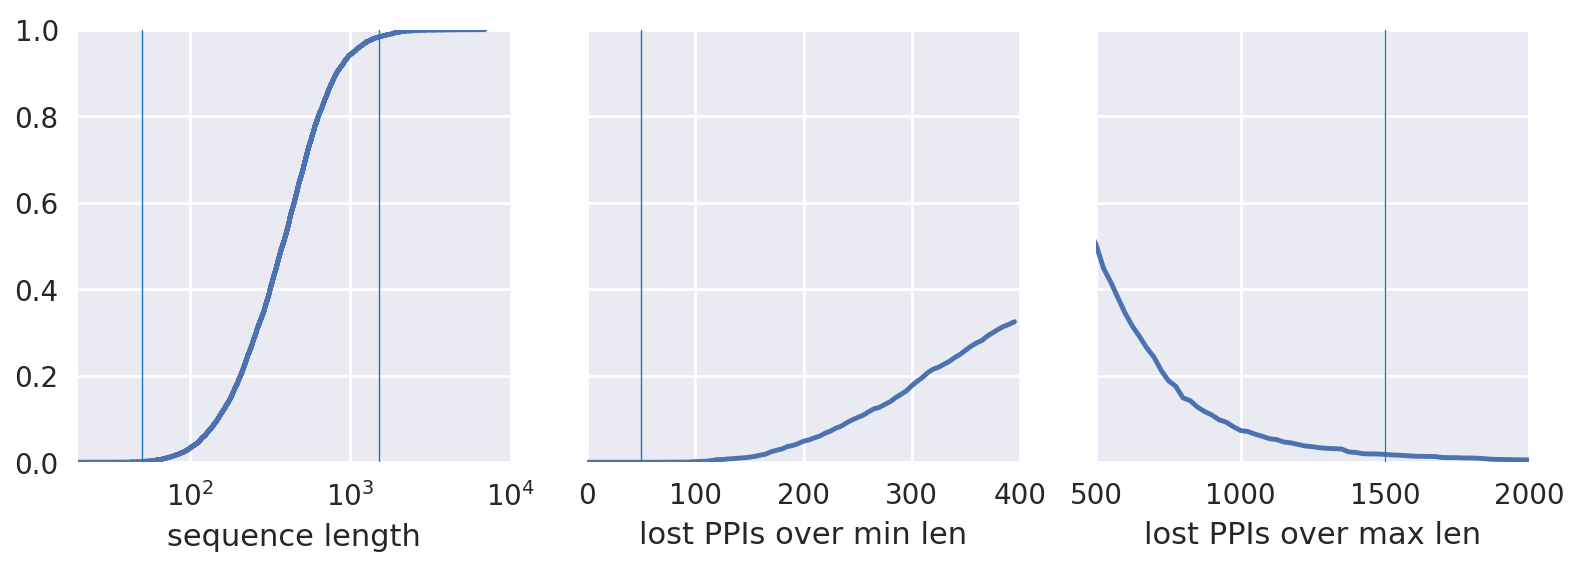

In [56]:
_huri_hash_ppis, _huri_seqs, fig = filter_ppis_and_fasta_by_len(
    huri_hash_ppis, huri_seqs, c.min_seq_len, c.max_seq_len)
len(huri_seqs), len(_huri_seqs)

#### test: save seqs + positives

In [57]:
huri_hash_ppis = _huri_hash_ppis
huri_seqs = _huri_seqs

In [58]:
_ = SeqIO.write(huri_seqs.values(), c.test_raw_fasta, 'fasta')
huri_hash_ppis.to_csv(c.test_raw_tsv, sep='\t', header=True, index=False)
c.test_raw_fasta, c.test_raw_tsv

(PosixPath('huri/huri_test_raw.fasta'), PosixPath('huri/huri_test_raw.tsv'))

## Test + validation: redundancy-reduce

Use [rostclust](https://git.rostlab.org/bernhoferm/mmseqs2-uniqueprot/-/tree/F_typer_app) to create non-redundant `test` and `validation` sets. <br> Don't run the next cells in the wrong order, and don't forget to copy the files back and forth if you are running `rostclust` elsewhere! <br>In particular, copy files after `shrink_files_both_ways`.

In [59]:
c.hval_config

{'shortAlignmentLen': 50,
 'longSeqLen': 180,
 'reduceRandomAlign': False,
 'clusterThreshold': 20}

In [60]:
with c.hval_config_path.open('w') as json_file:
    json_file.write(json.dumps(hval_config, indent=4))

The flag below allows me to test this notebook without the MMseqs2 runs. Leave `rostclust` at `False` and copy the two result files to this folder; or run `rostclust uniqueprot[2D]` from this system.

Haven't transferred these two runs to SLURM yet, sorry!

In [61]:
c.rostclust

'/home/quirin/mambaforge/envs/ppi/bin/rostclust'

In [ ]:
# redundancy-reduce the test set
run_uniqueprot(c.test_raw_fasta, c.test_rr_fasta,
               c.hval_config_path, not c.rostclust)

In [ ]:
# and validation
run_uniqueprot(c.val_raw_fasta, c.val_rr_fasta,
               c.hval_config_path, not c.rostclust)

In [92]:
fastalen = lambda _file: len([r.id for r in SeqIO.parse(_file, 'fasta')])

In [ ]:
# also drop PPIs accordingly
assert c.test_rr_fasta.is_file()
shrink_files_both_ways(c.test_raw_tsv, c.test_rr_fasta,
                       new_tsv_name=c.test_rr_tsv)
c.test_seqs = fastalen(c.test_rr_fasta)
assert c.val_rr_fasta.is_file()
shrink_files_both_ways(c.val_raw_tsv, c.val_rr_fasta,
                       new_tsv_name=c.val_rr_tsv)
c.val_seqs = fastalen(c.val_rr_fasta)

## Prepare proteomes
#### filter by len and id

In [ ]:
if c.add_proteomes:
    filter_proteomes(c.pp, c.min_seq_len, c.max_seq_len,
                     None if (hasattr(c, 'legacy') and c.legacy)
                     else c.train_raw_fasta)

#### run separately: faster
Separately clustering the proteomes against the test/validation set and then redundancy-reducing each one is faster and might lead to a more balanced combined proteome set that is better fit to sample from than merging all proteomes first and then running the two steps on huge files.

If available, run this on a SLURM cluster:

In [61]:
c.slurm, c.slurm_node_limit

(False, 15)

In [ ]:
if c.slurm:
    import snakemake

    snakemake.snakemake(snakefile='Snakefile',
                        config=c.to_dict() | dict(pkg_root=package_root),
                        nodes=c.slurm_node_limit,
                        cluster=f'sbatch -p All -N 1')

#### train: cluster against val
Mind that `train_species` and `val_species` may overlap! We deal with that later.

In [ ]:
s = None
if not c.slurm:
    s = rr_pattern_proteomes(
        c.train_species, c.pp, '{sp}.fasta', 'val',
        c.val_rr_fasta, c.hval_config_path, not c.rostclust)
s

#### train: cluster against test

In [ ]:
if not c.slurm:
    s = rr_pattern_proteomes(
        c.train_species, c.pp, '{sp}_nr_val.fasta', 'valtest',
        c.test_rr_fasta, c.hval_config_path, not c.rostclust)
s

These `_nr_valtest.fasta` proteomes are now ready to be used as negatives for the train set!

#### val: cluster against val

In [ ]:
if not c.slurm:
    # this is the same as the first call, just for different files!
    s = rr_pattern_proteomes(
        c.val_species, c.pp, '{sp}.fasta', 'val',
        c.val_rr_fasta, c.hval_config_path, not c.rostclust)
s

#### val: redundancy-reduce

In [ ]:
if not c.slurm:
    # now a 1D run -> no database/reference FASTA
    s = rr_pattern_proteomes(
        c.val_species, c.pp, '{sp}_nr_val.fasta', 'val',
        None, c.hval_config_path, not c.rostclust)
s

#### val: merge

In [ ]:
val_concat = c.pp / 'val_proteome_concat.fasta'
val_concat_rr = val_concat.with_stem(val_concat.stem + '_rr')

In [ ]:
merge_pattern_proteomes(c.val_species, val_concat, c.pp, '{sp}_rr_val.fasta')

#### val: redundancy-reduce merged set

In [ ]:
run_uniqueprot(val_concat, val_concat_rr, c.hval_config_path, not c.rostclust)

#### test: cluster against test

In [ ]:
if not c.slurm:
    s = run_uniqueprot2D(c.pp / '9606.fasta',
                         c.test_rr_fasta,
                         c.pp / '9606_nr_test.fasta',
                         c.hval_config_path, not c.rostclust)
s

#### test: redundancy-reduce

In [ ]:
if not c.slurm:
    s = run_uniqueprot(c.pp / '9606_nr_test.fasta', c.pp / '9606_rr_test.fasta',
                       c.hval_config_path, not c.rostclust)
s

The `swissprot/9606_rr_test.fasta` can be used as test set negatives directly; as this is a single-species set there is no combined set that needs redundancy reduction.

#### collate train/val/test proteomes
Create per-species dicts of potential negative interaction partners. Doing this once to save some `pull` calls.

In [ ]:
train_proteome = write_json(read_hash_proteomes(
    c.train_species, c.pp, '{sp}_nr_valtest.fasta'), c.train_proteome)

In [96]:
val_proteome = write_json(parse_val_proteome(val_concat_rr), c.val_proteome)

90745it [00:18, 5015.49it/s] 


In [ ]:
test_proteome = write_json(read_hash_proteomes(
    {9606}, c.pp, '{sp}_rr_test.fasta'), c.test_proteome)

## Generate negatives: examples
Negatives are sampled *per species*. Mind that the test set is human-only!
Start with the train set!
Re-write with proteomes, but without C123 labels.

In [35]:
c.strategy, c.ratio, c.seed, c.accept_homodimers

(<SamplingStrategy.BALANCED: 1>, 10.0, 42, False)

In [36]:
train_proteome = read_json(c.train_proteome)

In [37]:
train.head()

,hash_A,hash_B,species,minlen,maxlen,label
3,CRC-48F409F4E28F37BE,CRC-9AC87796A0BA67D9,632,170,833,1
1,CRC-4A7DEB955583CB27,CRC-6D6C1B4ED5C94EC7,632,266,334,1
0,CRC-5E21543540EBF92B,CRC-8561A9A0C1A2E169,632,95,326,1
2,CRC-8049DCC1A80C7391,CRC-9AC87796A0BA67D9,632,170,258,1
5,CRC-BED64D5961AA5E38,CRC-D4C3706260D2937A,632,207,780,1


In [38]:
train.species.value_counts().rename('n_ppis')

3702       42794
7227       31832
559292     25498
6239       13694
192222     10863
10090       4186
284812      3302
243276      3294
1111708     2944
83333       2707
85962       2068
237561        26
10299         10
632            5
9986           3
2697049        3
1392           2
333760         1
Name: n_ppis, dtype: int64

#### tiny examples

In this symmectric adjacency matrix, true PPIs and interactions that are not allowed as negatives are shown in blue. This often includes the diagonal; homodimers. Selected negatives are in red. The last row/column indicates *wanted* interactions that could not be satisfied in the existing set; with darker/lighter red indicating more than one extra interaction for the protein in that row/column. These extra negative interaction partners were drawn from SwissProt proteomes.

#### small example

#### multi-species example

#### tests from APID train

In this example, the number of available negatives falls far short of the target. The adjacency matrix is completely filled; and each protein would *should* get more than one extra negative interaction partner. However, we see that only 7 proteins in the non-redundant SwissProt proteome for this species were not already in the given set of PPIs, and we would actually need 30 to generate negatives at the target ratio.

## APID train
#### generate negatives

In [ ]:
# sanity check if there are any proteins in test that
# were already in train. re: "do not add back in identical ones"
assert not ({r.id for r in SeqIO.parse(c.train_raw_fasta, 'fasta')} & {
    r.id for r in SeqIO.parse(c.test_rr_fasta, 'fasta')})

In [ ]:
train = pd.read_csv(c.train_raw_tsv, sep='\t', header=0)
train_seqs = SeqIO.to_dict(SeqIO.parse(c.train_raw_fasta, 'fasta'))
len(train), len(train_seqs)

In [ ]:
train_ppis, train_negs, train_bias, _ = make_negatives(train, c, train_proteome)

1476474 negatives with overall 0.994 and average per-species bias of 0.974±0.078 (std)

#### bias

In [ ]:
c.train_bias = train_bias.set_index('species').to_dict()['bias']
train_bias.sort_values(by='bias')

In [ ]:
with mpl.rc_context({'figure.dpi': 72}):
    _ = plot_bias(train_ppis, train_negs, train_bias, c.ratio)
# fig.savefig('train_bias.png', transparent=False)

#### degrees
Evaluate how close the real ratio of negative : positive interactions per protein is to our target ratio

In [ ]:
with mpl.rc_context({'figure.dpi': 72}):
    fig, fig2, tdf, tnsp = plot_ratio_degree(
        train_ppis, train_negs, c.ratio, taxonomy)
# ax = fig.axes[0]
# ax.set(xlim=(1.8, 10.5))
# ax.annotate('SARS-CoV 2', xy=(2.5, 2.8), size=9)  # 2697049
# ax.annotate('Treponema', xy=(4.5, 80), size=9)  # 243276
# ax.annotate('Campylobacter', xy=(7, 200), size=9)  # 192222
# for sfx in ['png', 'pdf', 'svg']:
#     fig.savefig(f'train_ratio_degree.{sfx}', transparent=False, dpi=300)
#     fig2.savefig(f'train_negative_degree.{sfx}', transparent=False, dpi=300)

In [ ]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degrees_wide(train_ppis, train_negs, taxonomy, False,
                           [3702, 7227, 284812, 10090, 192222, 10299, 632, 2697049])
fg.savefig('train_degree_wide.svg')

In [ ]:
order = (taxonomy.loc[taxonomy.species.isin(train.species)]
             .sort_values(by='n_ppis')['species'][::-1])
with mpl.rc_context({'figure.dpi': 72}):
    g, h = plot_ratio_grids(tdf, order, c.ratio)

In [ ]:
desc = (tdf  #.loc[df.degree <= 3]
        .groupby('species')
        .describe()
        ['ratio']
        .sort_values(by='count')
        .round(2)
        .convert_dtypes()
        )
desc

#### save
The PPIs are easy:

In [ ]:
train_all = pd.concat((train_ppis, train_negs))
train_all.to_csv(c.train_tsv, sep='\t', header=True, index=False)
c.train_size = len(train_all)
c.train_size, c.train_tsv

But update the set of sequences with the added SwissProt proteins.

In [ ]:
assert not set(np.unique(train_ppis.iloc[:, [0, 1]])) - train_seqs.keys()

In [ ]:
train_extra = get_proteome_seqs(train_proteome, train_seqs, train_negs)
_ = SeqIO.write(values_sorted_by_key(train_extra),
                c.pp / 'train_extra.fasta', 'fasta')
train_seqs.update(train_extra)
c.train_extra = len(train_extra)
c.train_extra

In [ ]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_fasta, 'fasta')
len(train_seqs), c.train_fasta

In [ ]:
assert len(train_all), len(train_seqs) == shrink_both_ways(
    train_all.copy(), train_seqs.copy())

## APID validation
#### generate negatives
The `val` DataFrame is not up-to-date, use the contents of `val_rr_tsv` and `val_rr_fasta` instead!

In [ ]:
val = pd.read_csv(c.val_rr_tsv, sep='\t', header=0)
val_seqs = SeqIO.to_dict(SeqIO.parse(c.val_rr_fasta, 'fasta'))
len(val), len(val_seqs)

In [ ]:
set(val.species)

In [105]:
val_proteome = read_json(c.val_proteome)

In [ ]:
with mpl.rc_context({'figure.dpi': 64}):
    val_ppis, val_negs, val_bias, _ = make_negatives(val, c, val_proteome)

5902 negatives with overall 0.996 and average per-species bias of 0.984±0.031 (std)

#### bias

In [ ]:
if type(val_bias) == np.float64:
    c.val_bias = val_bias
else:
    assert type(val_bias) == pd.DataFrame
    c.val_bias = val_bias.set_index('species').to_dict()['bias']

    with mpl.rc_context({'figure.dpi': 100}):
        fig = plot_bias(val_ppis, val_negs, val_bias, c.ratio)
    fig.savefig('val_bias.png', transparent=False)

#### degrees

In [ ]:
with mpl.rc_context({'figure.dpi': 100}):
    fig, fig2, vdf = plot_ratio_degree(val_ppis, val_negs, c.ratio, taxonomy)
fig.savefig('val_ratio_degree.png', transparent=False)

Are we running out of extra proteins again?

In [ ]:
vdf.loc[vdf.ratio != c.ratio]

In [ ]:
if 37296 in c.val_species:
    with mpl.rc_context({'figure.dpi': 64}):
        v_ppis, v_negs, v_bias, _ = make_negatives(
            val.loc[val.species == 37296].copy(), c, val_proteome)

Yes we are running out of extra (SwissProt) proteins again!

#### save
First, save the PPIs as a `TSV`. This is straightforward, but we will overwrite that file right after clustering the `FASTA`.

In [ ]:
val_all = pd.concat((val_ppis, val_negs))
val_all.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_size = len(val_all)
c.val_size, c.val_tsv

In [ ]:
assert not set(np.unique(val_ppis.iloc[:, [0, 1]])) - val_seqs.keys()

In [ ]:
val_extra = get_proteome_seqs(val_proteome, val_seqs, val_negs)
_ = SeqIO.write(values_sorted_by_key(val_extra),
                c.pp / 'val_extra.fasta', 'fasta')
c.val_extra = len(val_extra)
c.val_extra, len(val_seqs)

In [ ]:
val_seqs.update(val_extra)

In [ ]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_fasta, 'fasta')
len(val_seqs), c.val_fasta

In [ ]:
assert len(val_all), len(val_seqs) == shrink_both_ways(
    val_all.copy(), val_seqs.copy())

#### cluster against train
Clustering the `APID` validation set against the `APID` train set gives us **C1-3** labels for the validation set.

In [ ]:
run_uniqueprot2D(c.val_fasta, c.train_fasta, c.val_c3_fasta,
                 c.hval_config_path, not c.rostclust)

#### label PPIs

In [ ]:
val_pairs = make_c_classes(c.val_tsv, c.val_c3_fasta, c.val_fasta)

#### class sizes

In [ ]:
with mpl.rc_context({'figure.dpi': 128}):
    fig, c.val_sizes = plot_c_classes(val_pairs)
for sfx in ['png', 'svg']:
    fig.savefig(f'val_cclasses.{sfx}', transparent=False, dpi=300)

In [ ]:
# sizes of the sets of positives per species
dict(val_ppis.species.value_counts())

#### save

In [ ]:
if not (bak := c.val_tsv.with_suffix('.tsv.bak')).is_file():
    shutil.move(c.val_tsv, bak)
val_pairs.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_tsv

## HuRI test
#### generate negatives
Read in the files first ...

In [ ]:
test = pd.read_csv(c.test_rr_tsv, sep='\t', header=0)
test_seqs = SeqIO.to_dict(SeqIO.parse(c.test_rr_fasta, 'fasta'))
len(test), len(test_seqs)

In [ ]:
set(test.species)

In [ ]:
test_proteome = read_json(c.test_proteome)
len(test_proteome[9606])

In [ ]:
with mpl.rc_context({'figure.dpi': 64}):
    test_ppis, test_negatives, c.test_bias, _ = make_negatives(
        test, c, test_proteome)

In [ ]:
test_ppis.head()

In [ ]:
test_negatives.head()

#### bias
As the test set contains only single species, this is just a number

In [ ]:
c.test_bias

#### degrees

In [ ]:
with mpl.rc_context({'figure.dpi': 100}):
    fig, fig2, tdf = plot_ratio_degree(test_ppis, test_negatives, c.ratio, taxonomy)
fig.savefig('test_ratio_degree.png', transparent=False)

In [ ]:
tdf.loc[tdf.ratio != c.ratio]

#### save
First, save the PPIs as a `TSV`. This is straightforward, but we will overwrite that file right after clustering the `FASTA`.

In [ ]:
test_all = pd.concat((test_ppis, test_negatives))
test_all.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_size = len(test_all)
c.test_size, c.test_tsv

In [ ]:
assert not set(np.unique(test_ppis.iloc[:, [0, 1]])) - test_seqs.keys()

In [ ]:
test_extra = get_proteome_seqs(test_proteome, test_seqs, test_negatives)
_ = SeqIO.write(values_sorted_by_key(test_extra),
                c.pp / 'test_extra.fasta', 'fasta')
c.test_extra = len(test_extra)
c.test_extra, len(test_seqs)

In [ ]:
test_seqs.update(test_extra)

In [ ]:
_ = SeqIO.write(values_sorted_by_key(test_seqs), c.test_fasta, 'fasta')
len(test_seqs), c.test_fasta

In [ ]:
assert len(test_all), len(test_seqs) == shrink_both_ways(
    test_all.copy(), test_seqs.copy())

#### cluster against train
Clustering the `HuRI` test set against the `APID` train set gives us **C1-3** labels for the test set.

In [ ]:
run_uniqueprot2D(c.test_fasta, c.train_fasta, c.test_c3_fasta,
                 c.hval_config_path, not c.rostclust)

#### label PPIs

In [ ]:
test_pairs = make_c_classes(c.test_tsv, c.test_c3_fasta, c.test_fasta)

#### class sizes

In [ ]:
with mpl.rc_context({'figure.dpi': 128}):
    fig, c.test_sizes = plot_c_classes(test_pairs)
for sfx in ['png', 'svg']:
    fig.savefig(f'test_cclasses.{sfx}', transparent=False, dpi=300)

#### save

In [ ]:
if not (bak := c.test_tsv.with_suffix('.tsv.bak')).is_file():
    shutil.move(c.test_tsv, bak)
test_pairs.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_tsv

---

In [ ]:
with Path(f'cfg.json').open('w') as json_file:
    json_file.write(c.to_json(indent=2))
print(c.to_json(indent=2))

---

In [142]:
_ = plot_test_ratios(test_pairs, c.ratio)

NameError: name 'test_pairs' is not defined

## Re-plot interactome sizes

In [292]:
!pwd

/home/quirin/PYTHON/ppi/data/ppi_dataset/results/results/7074


In [10]:
def fetch_network_sizes(all_pairs):
    return (pd.DataFrame(all_pairs.species.value_counts().rename('n_ppis'))
            .join(pd.DataFrame(
        all_pairs[['hash_A', 'hash_B', 'species']]
            .melt(id_vars='species')[['value', 'species']]
            .drop_duplicates().groupby('species').size()))
            .reset_index().rename(columns={0: 'n_proteins', 'index': 'species'}))


def fetch_network_sizes_from_tsv(tsv):
    all_pairs = pd.read_csv(tsv, sep='\t', header=0)
    all_pairs = all_pairs.loc[all_pairs.label == 1]
    return fetch_network_sizes(all_pairs)


dfs = list()
for name, path in zip(['train', 'validate', 'test'],
                      [c.train_tsv, c.val_tsv, c.test_tsv]):
    df = fetch_network_sizes_from_tsv(path)
    df['set_name'] = name
    dfs.append(df)
df = pd.concat(dfs)

In [11]:
df

,species,n_ppis,n_proteins,set_name
0,3702,42794,9042,train
1,7227,31832,8522,train
2,559292,25498,5438,train
3,6239,13694,5108,train
4,192222,10863,1272,train
5,10090,4186,3062,train
6,284812,3302,1869,train
7,243276,3294,684,train
8,1111708,2944,1819,train
9,83333,2707,1594,train


In [ ]:
before = pd.concat(fetch_network_sizes(_l) for _l in [hash_ppis, huri_hash_ppis])
before

In [476]:
df = df.merge(before, on='species', how='left', suffixes=['', '_r']).convert_dtypes()

In [477]:
df = df.merge(taxonomy[['species', 'name']], on='species', how='left')
df.loc[df.species == 9606, 'name'] = 'Homo sapiens'
df = df.sort_values(by='n_ppis')
df

,species,n_ppis,n_proteins,set_name,n_ppis_r,n_proteins_r,name
17,333760,1,2,train,1,2,Human papillomavirus type 16
16,1392,2,4,train,2,4,Bacillus anthracis
14,9986,3,6,train,3,6,Oryctolagus cuniculus
15,2697049,3,4,train,3,4,Severe acute respiratory syndrome coronavirus 2
13,632,5,9,train,5,9,Yersinia pestis
27,10377,9,13,validate,14,15,Human herpesvirus 4 strain B95-8
12,10299,10,16,train,10,16,Human alphaherpesvirus 1 strain 17
26,8355,13,23,validate,43,68,Xenopus laevis
25,9031,16,27,validate,34,54,Gallus gallus
24,7955,25,34,validate,109,123,Danio rerio


In [14]:
dscript_dir = Path('/home/quirin/PYTHON/ppi-t5/ppi/data/pairs/ref_tsv')
!cat "$dscript_dir/human_train.tsv" "$dscript_dir/human_test.tsv" > "$dscript_dir/human.tsv"

In [15]:
dts = dict()
for tsv in dscript_dir.glob('*.tsv'):
    dt = pd.read_csv(tsv, sep='\t', header=None, names=['A', 'B', 'C'])
    dt = dt.loc[dt.C > 0].drop_duplicates()
    dts[tsv.stem] = len(dt), len(np.unique(dt.iloc[:, [0, 1]]))
dts

{'worm_test': (5000, 2384),
 'human_train': (38346, 7472),
 'human': (47932, 7865),
 'mouse_test': (5000, 3499),
 'ecoli_test': (2000, 949),
 'yeast_test': (5000, 2344),
 'fly_test': (5000, 2148),
 'human_test': (9586, 4656)}

In [16]:
!rm "$dscript_dir/human.tsv"

In [ ]:
dt = pd.DataFrame(dts).T.reset_index().rename(columns={'index': 'species', 0: 'n_ppis', 1: 'n_proteins'})
dt = dt.loc[~dt.species.str.startswith('human_')]
lookup = {'worm': 6239, 'human': 9606,
          'mouse': 10090, 'ecoli': 83333,
          'yeast': 559292, 'fly': 7227}
dt.species = dt.species.apply(lambda s: lookup[s.split('_')[0]])
dt['set_name'] = 'D-SCRIPT'
dt = dt.merge(taxonomy[['species', 'name']], on='species', how='left')
dt.loc[dt.species == 9606, 'name'] = 'Homo sapiens'
dt

In [482]:
dd = pd.concat((df, dt))
# dd = dd.sort_values(by='n_ppis')
dd

,species,n_ppis,n_proteins,set_name,n_ppis_r,n_proteins_r,name
17,333760,1,2,train,1,2,Human papillomavirus type 16
16,1392,2,4,train,2,4,Bacillus anthracis
14,9986,3,6,train,3,6,Oryctolagus cuniculus
15,2697049,3,4,train,3,4,Severe acute respiratory syndrome coronavirus 2
13,632,5,9,train,5,9,Yersinia pestis
27,10377,9,13,validate,14,15,Human herpesvirus 4 strain B95-8
12,10299,10,16,train,10,16,Human alphaherpesvirus 1 strain 17
26,8355,13,23,validate,43,68,Xenopus laevis
25,9031,16,27,validate,34,54,Gallus gallus
24,7955,25,34,validate,109,123,Danio rerio


In [627]:
def plot_interactome_new(dd, df, xcol='n_ppis', min_x=1, asp=1.4, h=4):
    tax = dd
    df = df.copy().sort_values(by=xcol)
    pal = {'train': '#1E88E5', 'validate': '#D81B60',
           'test': '#FFC107', 'D-SCRIPT': '#004D40'}

    j = sns.catplot(
        data=tax,
        x=xcol,
        y='name',
        hue='set_name',
        palette=pal,
        order=list(df.name)[::-1],
        s=7,
        height=len(set(tax.species)) / h,
        aspect=asp,
        zorder=1000,
        legend=True,
    )
    ax = j.ax
    ax.set(box_aspect=1 / asp)
    j.set(xscale='log', xlabel=None,
          ylim=(None, -.5), xlim=(None, max(tax.n_ppis) * 1.4))

    ax.get_yaxis().set_visible(False)
    j.despine(left=True, bottom=True)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    fk = len(df)
    for i, (idx, row) in enumerate(df.iterrows()):
        sp, nppi, nprot, set_name, nppir, nprotr, name = row
        y = fk - i - 1
        if xcol == 'n_ppis':
            x, x2 = nppi, nppir
        else:
            x, x2 = nprot, nprotr
        if x < x2:
            ax.plot((x, x2), (y, y), markersize=7,
                    color=pal[set_name], marker='o', markerfacecolor=None)
            x = x2
        if sp == 10090:
            x *= 1.2
        # elif sp == 9606:
        #     x *= 2
        ax.text(x * 1.2, y, name, ha='left', va='center', zorder=100)

    ax.xaxis.grid(True, 'minor', linewidth=0, alpha=.2, zorder=0)
    ax.xaxis.grid(True, 'major', linewidth=1, alpha=.4, zorder=0, color='.5')
    sns.move_legend(j, frameon=False, bbox_to_anchor=(min_x, 1),
                    bbox_transform=ax.transData,
                    title=None, ncol=1, loc='upper left')
    j.tight_layout()
    return j


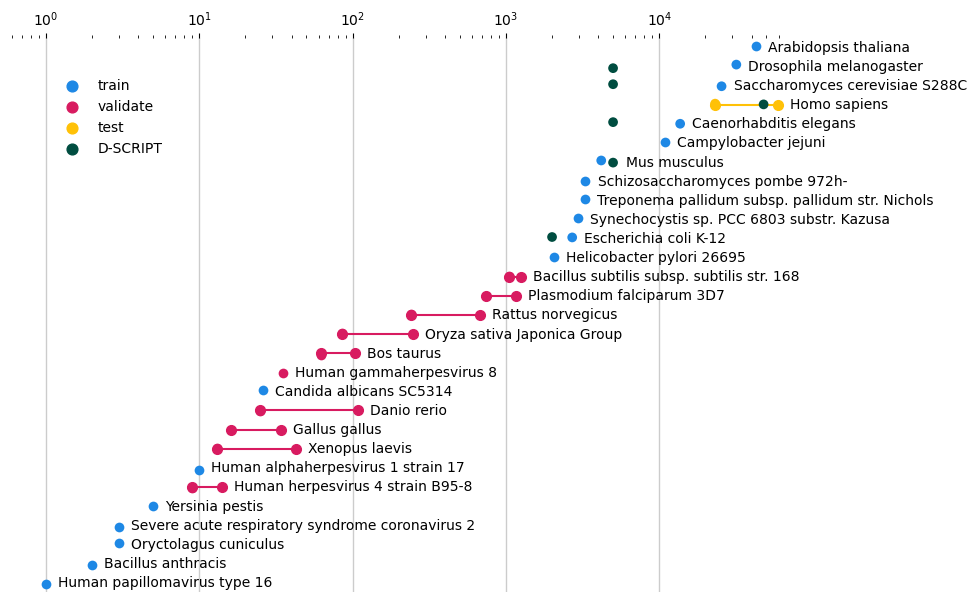

In [628]:
fig = plot_interactome_new(dd, df)
fig.savefig(f'n_ppis.svg')

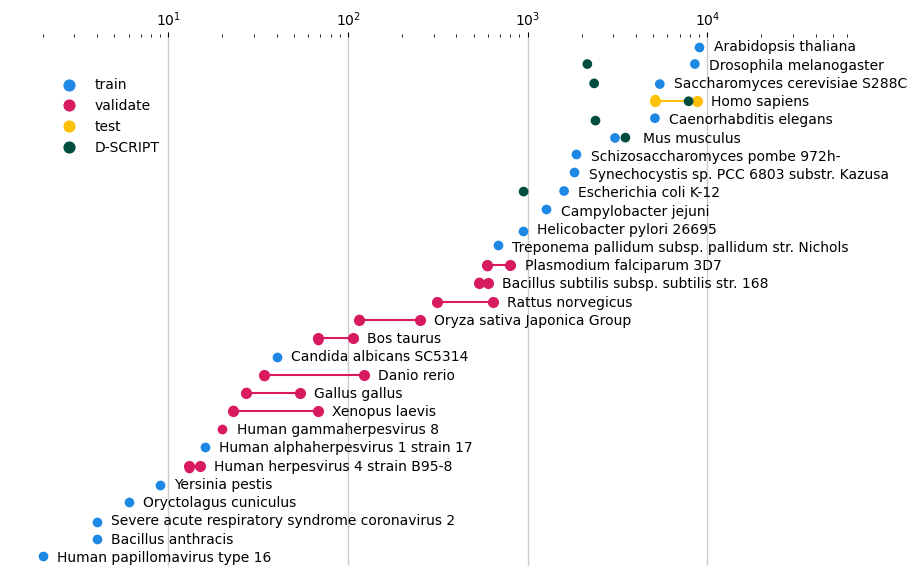

In [634]:
fig = plot_interactome_new(dd, df, xcol='n_proteins', min_x=2, asp=1.6, h=4.6)
fig.savefig(f'n_prots.svg')

In [508]:
print(dd.groupby('set_name')['n_proteins'].sum().to_latex())

\begin{tabular}{lr}
\toprule
{} &  n\_proteins \\
set\_name &             \\
\midrule
D-SCRIPT &       19189 \\
test     &        5138 \\
train    &       39430 \\
validate &        1747 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_150723/2331166548.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dd.groupby('set_name')['n_proteins'].sum().to_latex())


## Find the C-class off-by-one errors

In [271]:
_67 = pd.read_csv('7067_swissprot.txt', sep=' ', header=None, names=['crc', 'none', 'source'])
_67.source = _67.source.str[10:]
_67 = _67[['source', 'crc']].sort_values(by='source')
_67

,source,crc
0,10090.bak.fasta,514275ecf66d55dcc1946668962d90b7d0dc87c5a7014b...
1,10090.fasta,c7f74704a27639be2c3c379debb7cc14ddfed6fe1e8372...
2,10090_nr_val.fasta,75c94912fa21521932325c2cbb64e2c9772dc99af2af16...
3,10090_nr_valtest.fasta,b5e1e07f39d6178c4808f3446d579806eb61909d184661...
4,10116.bak.fasta,3a0fec291d0050d6372409f5250d4738409f2c696089b4...
...,...,...
116,test_extra.fasta,09a6af26f0f0c9722d07cd2497fc4a4d15a2e166021604...
117,train_extra.fasta,7bfd3820e26411ac05fb0f057459ca0976211a4680949f...
118,val_extra.fasta,d116eb56a266612630106a431544e7e87b2b4ba1eed2d5...
119,val_proteome_concat.fasta,fb963054c651397b726241b35f49728b6d109b89daa2a7...


In [272]:
_77 = pd.read_csv('7077_swissprot.txt', sep=' ', header=None, names=['crc', 'none', 'source'])
_77.source = _77.source.str[18:]
_77 = _77[['source', 'crc']].sort_values(by='source')
_77

,source,crc
0,10090.bak.fasta,514275ecf66d55dcc1946668962d90b7d0dc87c5a7014b...
1,10090.fasta,c7f74704a27639be2c3c379debb7cc14ddfed6fe1e8372...
2,10090_nr_val.fasta,75c94912fa21521932325c2cbb64e2c9772dc99af2af16...
3,10090_nr_valtest.fasta,b5e1e07f39d6178c4808f3446d579806eb61909d184661...
4,10116.bak.fasta,3a0fec291d0050d6372409f5250d4738409f2c696089b4...
...,...,...
116,test_extra.fasta,c3d056953c05bb9a01f159fa531dc5c14866d2b3a1ff3d...
117,train_extra.fasta,42ae8bb08c3acf09364df4cbfb7f6633a6679cef50a2ad...
118,val_extra.fasta,31d0f4afa8fcfd8ccdf68a84977b2605414dd261e1ab8b...
119,val_proteome_concat.fasta,fb963054c651397b726241b35f49728b6d109b89daa2a7...


In [273]:
both = _67.merge(_77, on='source')
both.loc[both.crc_x != both.crc_y]

,source,crc_x,crc_y
116,test_extra.fasta,09a6af26f0f0c9722d07cd2497fc4a4d15a2e166021604...,c3d056953c05bb9a01f159fa531dc5c14866d2b3a1ff3d...
117,train_extra.fasta,7bfd3820e26411ac05fb0f057459ca0976211a4680949f...,42ae8bb08c3acf09364df4cbfb7f6633a6679cef50a2ad...
118,val_extra.fasta,d116eb56a266612630106a431544e7e87b2b4ba1eed2d5...,31d0f4afa8fcfd8ccdf68a84977b2605414dd261e1ab8b...


## Re-plot the dataset bias

In [407]:
dscript_dir = Path('dscript')
bias = dict()
dts = list()
for tsv in dscript_dir.glob('*.tsv'):
    dt = pd.read_csv(tsv, sep='\t', header=None, names=['A', 'B', 'label'])
    dt['species'] = tsv.stem
    dts.append(dt)
    bias[tsv.stem] = estimate_bias(dt)
bias = pd.DataFrame(bias).T.reset_index().rename(
    columns={'index': 'species', 0: 'bias', 1: 'p'})[['species', 'bias']]
dscript_ppis = pd.concat(dts).convert_dtypes()
dscript_negs, dscript_ppis = [t[1] for t in dscript_ppis.groupby('label')]

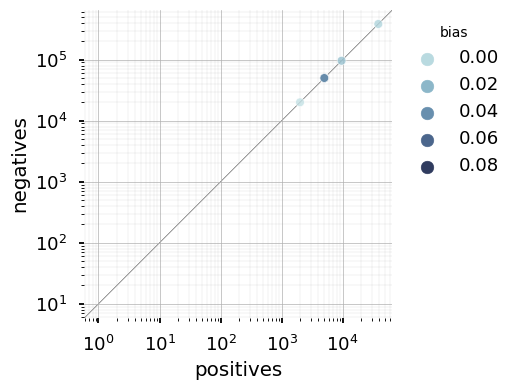

In [412]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_bias(dscript_ppis, dscript_negs, bias, c.ratio, pal=True)
fig.savefig('dataset_bias_dscript.svg')

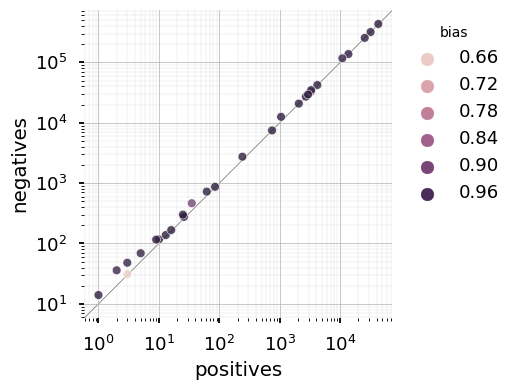

In [409]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_bias(pd.concat((train_ppis, val_ppis, test_ppis)),
                    pd.concat((train_negs, val_negs, test_negatives)),
                    pd.concat((train_bias, val_bias)), c.ratio)
fig.savefig('dataset_bias.svg')